## Import libraries 

In [1]:
## Import libraries
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import  Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from nltk.corpus import stopwords
from nltk import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import string
from sklearn.decomposition import LatentDirichletAllocation
from tensorflow.keras import Model
from tensorflow.keras import models

## Data preparation

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# load the dataset
data_train = pd.read_csv('gdrive/My Drive/train_tweets.csv')
data_test = pd.read_csv('gdrive/My Drive/test_tweets.csv')

In [4]:
data_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
data_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [6]:
# Delete unwanted columns
data_train = data_train[['label', 'tweet']]

In [7]:
# # create a dataframe and rename column names using texts and lables
trainDF = data_train.rename(columns={"label":"label", "tweet":"text"}) 
trainDF.head()

,label,text
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [8]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = train_test_split(trainDF['text'], trainDF['label'])

# label encode the target variable 
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

## Feature Engineering

In [9]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern = r'\w{1,}')
count_vect.fit(trainDF['text'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [10]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern = r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['text'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:546: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [12]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

vec_king = wv['king']

[=================================================-] 99.9% 1661.6/1662.8MB downloaded


In [13]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for word in wv.index2word:
    embeddings_index[word] = wv.word_vec(word)

# create a tokenizer 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(trainDF['text'])
word_index = tokenizer.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = pad_sequences(tokenizer.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = numpy.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [14]:
trainDF['char_count'] = trainDF['text'].apply(len)
trainDF['word_count'] = trainDF['text'].apply(lambda x: len(x.split()))
trainDF['word_density'] = trainDF['char_count'] / (trainDF['word_count']+1)
trainDF['punctuation_count'] = trainDF['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
trainDF['title_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
trainDF['upper_case_word_count'] = trainDF['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [15]:
pos_family = { 'noun' : ['NN','NNS','NNP','NNPS'],
              'pron' : ['PRP','PRP$','WP','WP$'],
              'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
              'adj' :  ['JJ','JJR','JJS'],
              'adv' : ['RB','RBR','RBS','WRB']}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

trainDF['noun_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'noun'))
trainDF['verb_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'verb'))
trainDF['adj_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adj'))
trainDF['adv_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'adv'))
trainDF['pron_count'] = trainDF['text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [16]:
# train a LDA Model
lda_model = LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
from wordcloud import WordCloud 

## Visualisation

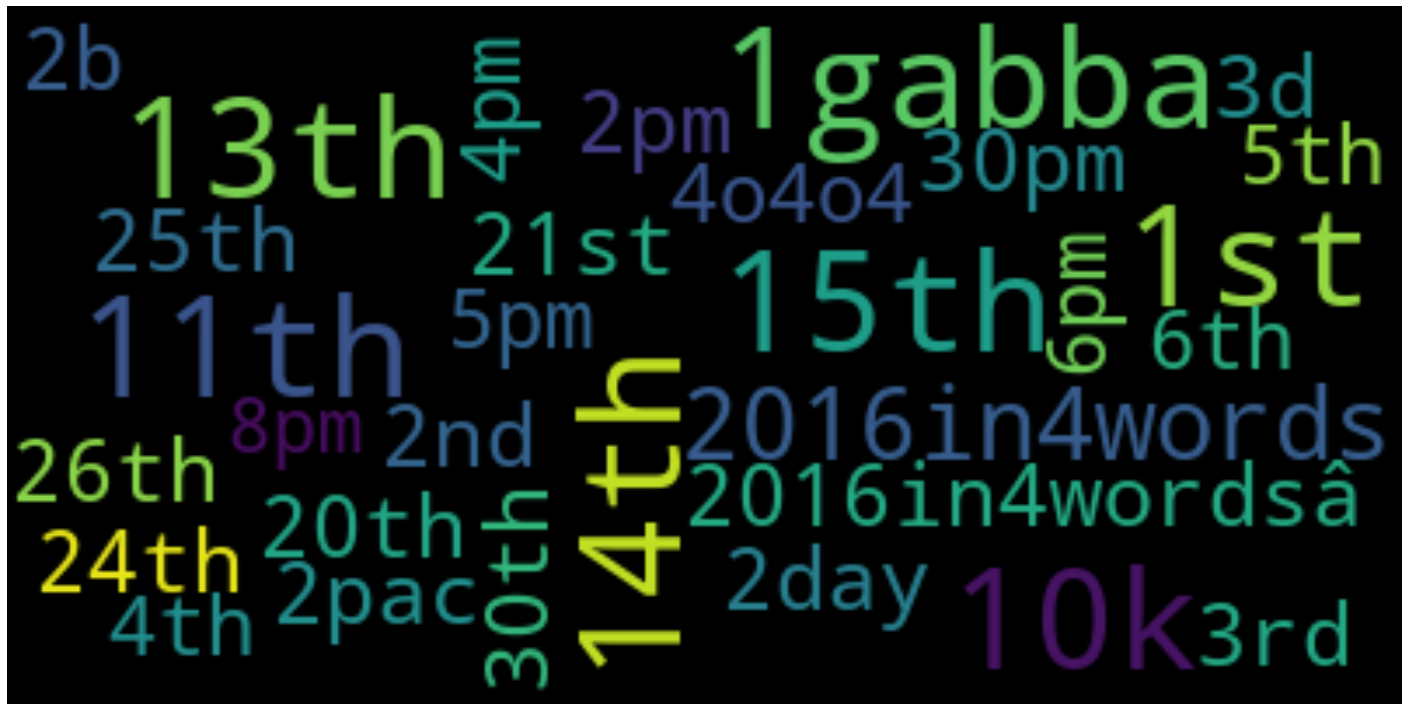

In [18]:
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


tfidf_vec_dict = tfidf_vect.vocabulary_
tfidf_vec_df = pd.DataFrame.from_dict(tfidf_vec_dict, orient='index', columns=['tfidf_vect'])

plot_word_cloud(tfidf_vec_df.sort_values(by=['tfidf_vect'], ascending=True).head(100))

## Model Building
### 1. CNN

In [19]:
import tensorflow

def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers  # We add a vanilla hidden layer:
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    
    # We project onto a single unit output layer, and squash it with a sigmoid
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = tensorflow.keras.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])
    
    return model

In [20]:
model = create_cnn()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70)]              0         
                                                                 
 embedding (Embedding)       (None, 70, 300)           13767000  
                                                                 
 spatial_dropout1d (SpatialD  (None, 70, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 68, 100)           90100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050  

In [21]:
history = model.fit(train_seq_x, train_y, batch_size=64, epochs=5, validation_data=(valid_seq_x, valid_y))

Epoch 1/5
375/375 [==============================] - 14s 6ms/step - loss: 0.1898 - acc: 0.9365 - val_loss: 0.1414 - val_acc: 0.9474
Epoch 2/5
375/375 [==============================] - 2s 4ms/step - loss: 0.1332 - acc: 0.9505 - val_loss: 0.1375 - val_acc: 0.9491
Epoch 3/5
375/375 [==============================] - 2s 5ms/step - loss: 0.1127 - acc: 0.9590 - val_loss: 0.1192 - val_acc: 0.9552
Epoch 4/5
375/375 [==============================] - 2s 5ms/step - loss: 0.0910 - acc: 0.9670 - val_loss: 0.1218 - val_acc: 0.9543
Epoch 5/5
375/375 [==============================] - 2s 4ms/step - loss: 0.0724 - acc: 0.9738 - val_loss: 0.1219 - val_acc: 0.9560


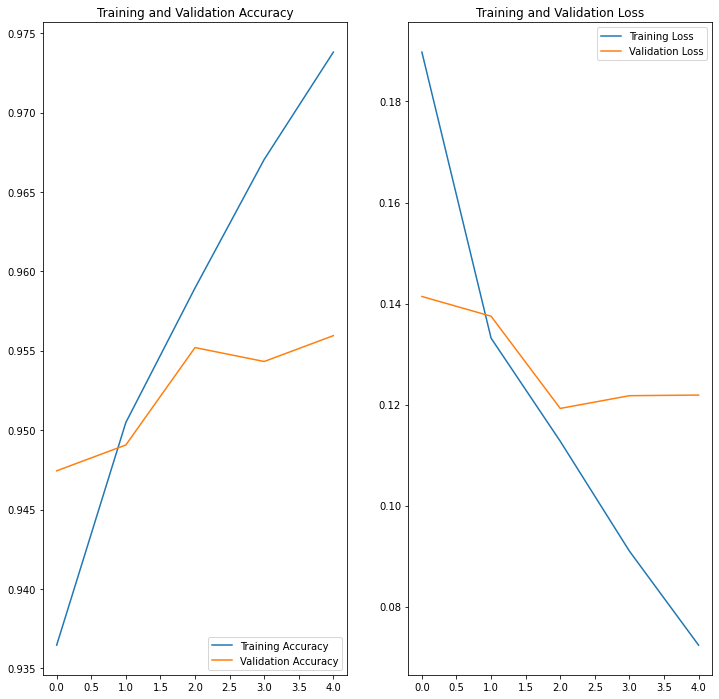

In [22]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = 5
epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
test_data = pd.read_csv('gdrive/My Drive/test_tweets.csv')